## PCA Visualization & Evaluation Example
#### Example: Runescape - Darkscape

In [107]:
import os
import pickle
from AlignmentFormat import load_kv
import matplotlib.pyplot as plt
import numpy as np
from utils import get_emb_matrices, evaluate
from sklearn.decomposition import PCA
from sklearn import preprocessing
from projections import ORTH_Projection
import faiss
from collections import Counter

In [2]:
with open("./training-monolingual/lexicon/train_lexicon_runescape-darkscape", "rb") as train:
    train_lexicon = pickle.load(train)
with open("./training-monolingual/lexicon/test_lexicon_runescape-darkscape", "rb") as test:
    test_lexicon = pickle.load(test)

In [49]:
# first 10 translation pairs
test_lexicon[:10]

[('<http://dbkwik.webdatacommons.org/runescape/resource/Slaughtered_monk>',
  '<http://dbkwik.webdatacommons.org/darkscape/resource/Slaughtered_monk>'),
 ('<http://dbkwik.webdatacommons.org/runescape/resource/Gublinch_jailmate>',
  '<http://dbkwik.webdatacommons.org/darkscape/resource/Gublinch_jailmate>'),
 ('<http://dbkwik.webdatacommons.org/runescape/resource/Apollo>',
  '<http://dbkwik.webdatacommons.org/darkscape/resource/Apollo>'),
 ('<http://dbkwik.webdatacommons.org/runescape/resource/Simon>',
  '<http://dbkwik.webdatacommons.org/darkscape/resource/Simon>'),
 ('<http://dbkwik.webdatacommons.org/runescape/resource/Sorin>',
  '<http://dbkwik.webdatacommons.org/darkscape/resource/Sorin>'),
 ('<http://dbkwik.webdatacommons.org/runescape/resource/Another_Slice_of_H.A.M.>',
  '<http://dbkwik.webdatacommons.org/darkscape/resource/Another_Slice_of_H.A.M.>'),
 ('<http://dbkwik.webdatacommons.org/runescape/resource/Red_Axe_cat>',
  '<http://dbkwik.webdatacommons.org/darkscape/resource/Red

In [4]:
src_kv, tgt_kv = load_kv(src="runescape", tgt="darkscape") #size_src/size_tgt=200, ws=10

In [32]:
emb_src, emb_tgt = get_emb_matrices(src_kv, tgt_kv, test_lexicon, size_src=200, size_tgt=200, norm_bf=False)

In [33]:
projection = ORTH_Projection(src_kv, tgt_kv, train_lexicon, test_lexicon, size_src=200, size_tgt=200, norm_bf=False)
precisions = evaluate(projection.test_matrix_src, projection.test_matrix_tgt, projection.W, normalize=True)
X_src_projected = emb_src @ projection.W

The precision@ 1 is: 0.072
The precision@ 5 is: 0.204
The precision@ 10 is: 0.31


In [34]:
def visualize_PCA(start=0, end=5, annotate=True, save_file=None):
    projection = ORTH_Projection(src_kv, tgt_kv, train_lexicon, test_lexicon, size_src=200, size_tgt=200, norm_bf=False)
    X_src_projected = emb_src @ projection.W
    
    span = list(range(start,end))
    n = []
    for pair in np.array(test_lexicon)[span,:]:
        n.append(pair[0].split("/")[-1][:-1])

    normalizer_1 = preprocessing.Normalizer(norm='l2')
    normalizer_2 = preprocessing.Normalizer(norm='l2')

    X_src = normalizer_1.fit_transform(emb_src.T).T
    X_tgt = normalizer_1.transform(emb_tgt.T).T


    pca = PCA(n_components=2)
    X_src_lowdim = pca.fit_transform(X_src)
    X_tgt_lowdim = pca.transform(X_tgt)

    X_src_lowdim = normalizer_2.fit_transform(X_src_lowdim.T).T
    X_tgt_lowdim = normalizer_2.transform(X_tgt_lowdim.T).T

    X_src_projected = normalizer_1.transform(X_src_projected.T).T
    X_src_lowdim_projected = pca.transform(X_src_projected)
    X_src_lowdim_projected = normalizer_2.transform(X_src_lowdim_projected.T).T
    
    
    fig, ax = plt.subplots(figsize=(7,7))
    ax.scatter(X_src_lowdim[span,0], X_src_lowdim[span,1], label='runescape', c='blue',alpha=1.0)
    ax.scatter(X_src_lowdim_projected[span,0], X_src_lowdim_projected[span,1], label='runescape_projected', c='lightgreen',alpha=1.0)
    ax.scatter(X_tgt_lowdim[span,0], X_tgt_lowdim[span,1], label='darkscape', c='red',alpha=1.0)
    if annotate:
        for i, txt in zip(span,n):
            ax.annotate(txt, (X_src_lowdim[i,0], X_src_lowdim[i,1]))
            ax.annotate(txt, (X_tgt_lowdim[i,0], X_tgt_lowdim[i,1]))
            ax.annotate(txt, (X_src_lowdim_projected[i,0], X_src_lowdim_projected[i,1]))
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()
    if save_file:
        fig.savefig(save_file)

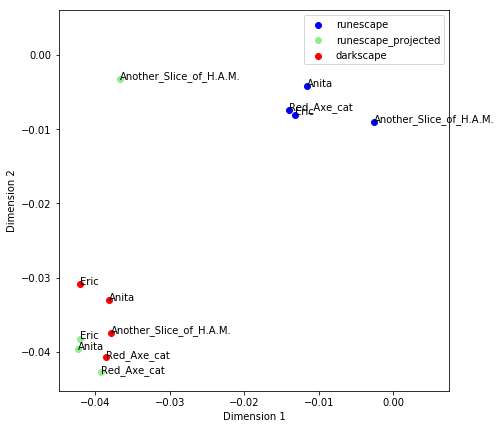

In [47]:
visualize_PCA(start=5, end=9, save_file="PCA_small.png")

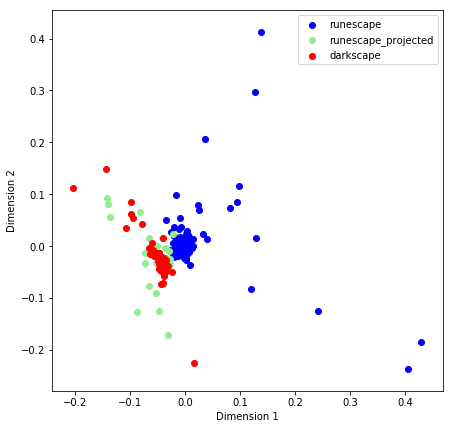

In [48]:
visualize_PCA(start=0, end=200, annotate=False, save_file="PCA_large.png")

#### Evaluation example

In [50]:
test_matrix_tgt_projected = projection.test_matrix_src @ projection.W
test_matrix_tgt_base = projection.test_matrix_tgt.copy()

test_matrix_tgt_projected = preprocessing.normalize(test_matrix_tgt_projected, axis=1, norm='l2')
test_matrix_tgt_base = preprocessing.normalize(test_matrix_tgt_base, axis=1, norm='l2')

size_tgt = test_matrix_tgt_projected.shape[1]
index = faiss.IndexFlatL2(size_tgt)
index.add(test_matrix_tgt_base.astype(np.float32))
D, I = index.search(test_matrix_tgt_projected.astype(np.float32), 20)

In [84]:
example_token = '<http://dbkwik.webdatacommons.org/darkscape/resource/Slaughtered_monk>'

def cleanse(token):
    pieces = token.split("/")
    return pieces[-2] + "/" + pieces[-1][:-1]

print(cleanse(example_token))

resource/Slaughtered_monk


In [86]:
I_names = [[cleanse(test_lexicon[j][1]) for j in line] for line in I]
I_corrects = [cleanse(test_lexicon[j][1]) for j in range(I.shape[0])]

In [109]:
# the top20 retrieved neighbors for the examples 170 to 180
I_names[170:180]

[['resource/Banana_Store',
  'resource/Artimeus',
  'resource/General_store_merchant',
  'resource/Banana_merchant',
  'resource/Neferti_the_Camel',
  'resource/Ali_the_Snake_Charmer',
  'resource/Menaphite_Leader',
  'resource/Tati',
  "resource/Brian_O'Richard",
  'resource/Kjut',
  'resource/Jorzik',
  'resource/Habibah',
  'resource/Obli',
  "resource/Tutab's_Magical_Market",
  "resource/Solihib's_Food_Stall",
  "resource/Obli's_General_Store",
  "resource/Reinald's_Smithing_Emporium",
  'resource/Embalmer',
  "resource/Faruq's_Tools_for_Games",
  'resource/Urist_Loric'],
 ['resource/Jeremy_Clerksin',
  "resource/Xuan's_Fresh_Produce",
  'resource/Wizard_Valina',
  'resource/Zemouregal',
  'resource/New_Varrock_Leather_Emporium',
  'resource/Cleaner',
  "resource/Gunnar's_Ground",
  'resource/Fred_the_Farmer',
  'resource/Rag_and_Bone_Man',
  'resource/Thrander',
  'resource/Armadyl',
  'resource/Habibah',
  'resource/Fremennik_man',
  'resource/Relomia,_Emissary_of_Sliske',
  'res

In [106]:
# the actual correct entity for the examples 170 to 180, often among the suggested neighbors
I_corrects[170:180]

['resource/Louie_Legs',
 "resource/Gunnar's_Ground",
 'resource/Ghosts_Ahoy',
 'resource/Heckel_Funch',
 'resource/Lanthus',
 'property/techsupport',
 'resource/Gerrant',
 'resource/Fur_trader_(Rellekka)',
 'resource/Miscellanian_General_Store',
 'property/bait']

In [110]:
top5_corpus = []
for line in I_names:
    top5_corpus += line[:5]

In [113]:
counts = Counter(top5_corpus)

In [114]:
counts_sorted = [(l, k) for k, l in sorted([(j, i) for i, j in counts.items()], reverse=True)]
sorted_words = [wc[0] for wc in counts_sorted]

In [116]:
counts_sorted

[('resource/Max', 49),
 ('resource/Orlando_Smith', 45),
 ('resource/Banker', 45),
 ('resource/Wilf', 41),
 ('resource/Captain_Rovin', 37),
 ('property/tools', 32),
 ('resource/Benny', 31),
 ('resource/Urist_Loric', 29),
 ('resource/Prized_dairy_cow', 28),
 ('resource/Garkor', 24),
 ('resource/Zombie_protester', 23),
 ('resource/Smoke_devil', 23),
 ('resource/Siegfried_Erkle', 23),
 ("resource/Tutab's_Magical_Market", 21),
 ("resource/Reinald's_Smithing_Emporium", 21),
 ('resource/Snake', 20),
 ('resource/Obli', 20),
 ("resource/Brian_O'Richard", 20),
 ('resource/Winkin', 19),
 ('resource/No._202', 19),
 ('resource/Mono', 19),
 ("resource/Goblin_Maitre_d'", 19),
 ('resource/Corporal_Boothe', 19),
 ('resource/Artimeus', 17),
 ('resource/Uwogo', 16),
 ('resource/The_Prisoner_of_Glouphrie', 16),
 ('resource/Magic_Guild_Store_-_Mystic_Robes', 16),
 ('resource/Elemental_Workshop_IV', 16),
 ('resource/Rachel', 15),
 ("resource/Obli's_General_Store", 15),
 ("resource/Keldagrim's_Best_Bread", 1